In [8]:
import os, sys
sys.path.append(str(pathlib.Path(__file__).parent.parent.parent))

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from numpy.fft import fftshift, fft2
from smallFuncs import saveImage
import pandas as pd
%matplotlib

Using matplotlib backend: MacOSX


## Functions

In [2]:
class Input:
    def __init__(self, Coordinates=[], full_image=[]):
        """ Coordinates: [x1,y1,z1, x2,y2,z2] """
        
        self.Coordinates = Coordinates
        self.Full_image = full_image / full_image.max()

        # Cropping the Signal & Noise
        x1,y1,z1, x2,y2,z2 = self.Coordinates
        self.Image = full_image[x1:x2,y1:y2,z1] / full_image.max()
        
        # PSD (power spectral density)
        self.PSD = np.mean(abs(fftshift(fft2(self.Image)))**2)

    def show(self, full_image=False):
        if full_image:

            # Showing full size input
            ax = plt.subplot(111)
            plt.imshow(self.Full_image[...,self.Coordinates[2]],cmap='gray')

            # Overlaying the boundingbox
            currentAxis = plt.gca()
            x1,y1,_, x2,y2,z2 = self.Coordinates
            currentAxis.add_patch(Rectangle([y1,x1],y2-y1,x2-x1,angle=0,fill=False,color='red'))

        else:
            # Showing cropped input
            plt.imshow(self.Image,cmap='gray')

def adding_WGN(im=[], noise_mean=0, noise_std=1):
    if noise_std>0:
        gaussian_noise_real = abs(np.random.normal(loc=noise_mean , scale = noise_std, size=im.shape))
        gaussian_noise_imag = abs(np.random.normal(loc=noise_mean , scale = noise_std, size=im.shape))
        gaussian_noise = gaussian_noise_real + 1j*gaussian_noise_imag
    else:
        gaussian_noise = np.zeros(im.shape) + 1j*np.zeros(im.shape)
        
    return abs(im + gaussian_noise), gaussian_noise

class measure_SNR_full_image:
    def __init__(self,noisy_image, Co_foreground, Co_background):
        self.Thalamus = Input(Coordinates=Co_foreground, full_image=noisy_image)
        self.Background = Input(Coordinates=Co_background, full_image=noisy_image)

        self.psd_noise = self.Background.PSD
        self.psd_signal = self.Thalamus.PSD - self.Background.PSD
        self.SNR1 = 10*np.log10(self.psd_signal/self.psd_noise) 

        self.SNR2 = self.Thalamus.Image.mean() / self.Background.Image.std()

def measure_SNR_cropped(signal,noise):

    PSD_signal = np.mean(abs(fftshift(fft2(signal)))**2)
    PSD_noise = np.mean(abs(fftshift(fft2(abs(noise))))**2)
    return 10*np.log10(PSD_signal/PSD_noise) 


## Old Method vs. New Method SNR Values

In [3]:
# Directory 
direcotry_main = '/'
direcotryF = direcotry_main + r'Google Drive/RESEARCH/Projects/Thalamus/Results/2nd Submission/suplementary results/SNR test/vimp2_967_08132013_KW/'
subject = 'vimp2_orig_SNR_10000/'
direcotry = direcotryF + subject

# for noise_std in [1,10,20,30,40,50,60,65,80,95,105,120,135,150,170]:
noise_std = 95

# Old Method
im_cropped = nib.load(direcotry + 'PProcessed.nii.gz').get_fdata()
imN, noise = adding_WGN(im_cropped, noise_mean=0, noise_std=noise_std)
SNR = measure_SNR_cropped(signal=im_cropped,noise=noise)

# New Method
n_slide = 120
im = nib.load(direcotry + 'WMnMPRAGE_bias_corr.nii.gz').get_fdata()
imN, noise = adding_WGN(im, noise_mean=0, noise_std=noise_std)
MSI = measure_SNR_full_image(noisy_image=im , Co_foreground=[100,165, n_slide, 115, 205, n_slide+1] , Co_background = [0,0, n_slide, 50, 50, n_slide+1])

print(f'noise_std: {noise_std} :   SNR Old Method -  Full Size: {MSI.SNR1:1.2f}    Cropped: {SNR:1.2f}')
print(f'noise_std: {noise_std} :   SNR  - New method {MSI.SNR2:1.2f}  ->  Equivalent ->  Old method : {SNR:1.2f}   ')


noise_std: 95 :   SNR Old Method -  Full Size: 14.00    Cropped: 17.07
noise_std: 95 :   SNR  - New method 19.15  ->  Equivalent ->  Old method : 17.07   


## Faster Version (Only reads the cropped part)

In [12]:
# New Method
n_slide = 120
full_im = nib.load(direcotry + 'WMnMPRAGE_bias_corr.nii.gz') # .get_fdata()
TH_msk = nib.load(direcotry + '/Label/1-THALAMUS.nii.gz').get_fdata()
SNRs = {}
SNRs['Added noise sd'] = []
SNRs['Foreground Mean'] = []
SNRs['Background SD'] = []
SNRs['Final Generated Noise SD'] = []
SNRs['SNR'] = []

for noise_std in [0,10,20,30,40,50,60,65,80,95,105,120,135,150,170]:
    # noise_std = 95
    # Cropping the Signal & Noise
    x1,y1,z1, x2,y2,z2 = [100,165, n_slide, 115, 205, n_slide+1]
    Thalamus = full_im.get_fdata()[x1:x2,y1:y2,z1]
    Thalamus2 = full_im.get_fdata()[...,n_slide][TH_msk[...,n_slide] > 0.5]

    x1,y1,z1, x2,y2,z2 = [0,0, n_slide, 50, 50, n_slide+1]
    background = full_im.get_fdata()[x1:x2,y1:y2,z1]

    ThalamusN, noise = adding_WGN(Thalamus, noise_mean=0, noise_std=noise_std)
    ThalamusN2, noise2 = adding_WGN(Thalamus2, noise_mean=0, noise_std=noise_std)
    backgroundN, noiseB = adding_WGN(background, noise_mean=0, noise_std=noise_std)

    SNR2 = ThalamusN.mean() / backgroundN.std()
    SNR2b = ThalamusN2.mean() / backgroundN.std()

    SNRs['Added noise sd'].append(noise_std)
    SNRs['Foreground Mean'].append(ThalamusN.mean())
    SNRs['Background SD'].append(backgroundN.std())
    SNRs['Final Generated Noise SD'].append(abs(noise).std())
    SNRs['SNR'].append(SNR2b)

    # print(noise_std,SNR2b)
    # print(f'Added noise_sd: {noise_std} : Thalamus Mean {ThalamusN.mean():1.1f}  background SD {backgroundN.std():1.2f}  Noise SD {abs(noise).std():1.2f}  SNR {SNR2b:1.2f} ')



In [26]:
df = pd.DataFrame(SNRs)
df.round(2)
# df.set_index('Added noise sd')

,Added noise sd,Foreground Mean,Background SD,Final Generated Noise SD,SNR
0,0,522.42,27.28,0.00,19.33
1,10,530.69,26.43,6.42,20.26
2,20,538.76,28.22,13.18,19.28
3,30,547.51,29.92,19.56,18.47
4,40,555.52,34.43,25.74,16.29
5,50,563.64,39.92,31.27,14.27
6,60,574.11,43.21,40.25,13.37
7,65,579.94,47.75,43.44,12.25
8,80,593.18,55.69,53.11,10.74
9,95,605.09,65.22,62.66,9.38


## Saving Noisy Image

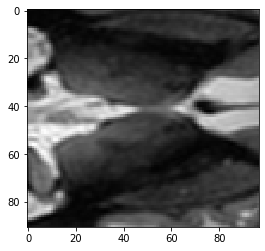

In [5]:
# sd original	SNR1 60	SNR2 20.0
# sd 60 	    SNR1 21	SNR2 11.4
# sd 95	        SNR1 17	SNR2 8.0
# sd 135	    SNR1 14	SNR2 6.0
# sd 150	    SNR1 13	SNR2 5.5
noise_std, SNR2 = 60, 11.4

im_croppedF = nib.load(direcotry + 'PProcessed.nii.gz')

im_cropped = im_croppedF.get_fdata()
imN, noise = adding_WGN(im_cropped, noise_mean=0, noise_std=noise_std)

plt.imshow(im_cropped[...,36]/im_cropped.max(),cmap='gray')
saveImage(imN,im_croppedF.affine,im_croppedF.header,direcotryF + f'vimp2_orig_SNR2_{SNR2}/PProcessed.nii.gz')

## Plotting the Output

Text(0.5, 1.0, 'SNR:   Old Method ) =  17.1    -   New Method =  19.2')

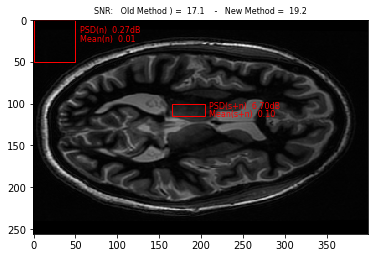

In [6]:
ax = plt.subplot(111)
plt.imshow(im[...,n_slide],cmap='gray')
currentAxis = plt.gca()

x1,y1,_, x2,y2,z2 = MSI.Thalamus.Coordinates
currentAxis.add_patch(Rectangle([y1,x1],y2-y1,x2-x1,angle=0,fill=False,color='red'))
ax.text(y2+5, x1+5, f'PSD(s+n) {MSI.psd_signal: 1.2f}dB',color='red',fontsize=8)
ax.text(y2+5, x1+15, f'Mean(s+n) {MSI.Thalamus.Image.mean(): 1.2f}',color='red',fontsize=8)

x1,y1,_, x2,y2,z2 = MSI.Background.Coordinates
currentAxis.add_patch(Rectangle([y1,x1],y2-y1,x2-x1,angle=0,fill=False,color='red'))
ax.text(y2+5, x1+15, f'PSD(n) {MSI.psd_noise: 1.2f}dB',color='red',fontsize=8)
ax.text(y2+5, x1+25, f'Mean(n) {MSI.Background.Image.mean(): 1.2f}',color='red',fontsize=8)

plt.title(f'SNR:   Old Method ) = {SNR: 1.1f}    -   New Method = {MSI.SNR2: 1.1f}',fontsize=8)

## Measuring from Template vs. Original Image

In [7]:
template = nib.load('/general/RigidRegistration/origtemplate.nii.gz').get_fdata()
Template = Input(Coordinates=[100,165, n_slide, 115, 205, n_slide+1], full_image=template)

print(f'SNR Old Method:    From Image:  {10*np.log10((MSI.Thalamus.PSD - MSI.Background.PSD)/MSI.Background.PSD):1.2f}   From Template: {10*np.log10(Template.PSD/MSI.Background.PSD):1.2f} ')

print(f'PSD tempalte  {Template.PSD:1.2f}    PSD image  {MSI.Thalamus.PSD:1.2f}    PSD background  {MSI.Background.PSD:1.2f}')

SNR Old Method:    From Image:  14.00   From Template: 15.71 
PSD tempalte  9.92    PSD image  6.97    PSD background  0.27
